In [4]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import rand, randn
from scipy.io import loadmat 

"""Simulate a balanced spiking neuronal network
 
    Parameters
    ----------
    dt : float
        Sampling interval of the simulation.
    T : float
        Duration of the simulation.
    tref : float
        Refractory time of the neurons.
    tm : float
        Time constant of the neurons.
    vreset : float
        The voltage neurons are set to after a spike.
    vpeak : float
        The voltage above which a spike is triggered
    n : int
        The number of neurons.
    td : float
        Synaptic decay time constant.
    tr : float
        Synaptic rise time constant.
    p : float
        Connection probability between neurons.
    offset : float
        A constant input into all neurons.
    g : float
        Scaling factor of synaptic strength
    seed : int
        The seed makes NumPy random number generator deterministic.
    nrec : int
        The number of neurons to record.
 
    Returns
    -------
    ndarray
        A 2D array of recorded voltages. Rows are time points,
        columns are the recorded neurons. Shape: (int(T/dt), nrec).
    """

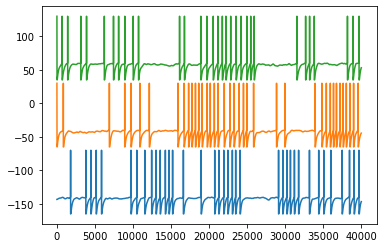

In [5]:
#data = loadmat('fd.mat')

def ref_spiked(dt=0.00005, T=2.0, tref=0.002, tm=0.01,
                             vreset=-65.0, vpeak=-40.0, n=2000, 
                             td=0.02, tr=0.002, p=0.1, 
                             offset=-40.00, g=0.04, seed=100, 
                             nrec=10):
    np.random.seed(seed)
      #Setup weight matrix""
    w = g * (randn(n, n)) * (rand(n, n) < p) / (np.sqrt(n) * p)
      
    # Set the row mean to zero
    row_means = np.mean(w, axis=1, where=np.abs(w) > 0)[:, None]
    row_means = np.repeat(row_means, w.shape[0], axis=1)
    w[np.abs(w) > 0] = w[np.abs(w) > 0] - row_means[np.abs(w) > 0]
 
    
    nt = round(T/dt)  # Number of time steps
    rec = np.zeros((nt, nrec))
 
    
    ipsc = np.zeros(n)  # Post synaptic current storage variable
    hm = np.zeros(n)  # Storage variable for filtered firing rates
    tlast = np.zeros((n))  # Used to set  the refractory times
    v = vreset + rand(n)*(30-vreset)  # Initialize neuron voltage
 
    
    for i in np.arange(0, nt, 1):
        inp = ipsc + offset  # Total input current
 
        # Voltage equation with refractory period
        # Only change if voltage outside of refractory time period
        dv = (dt * i > tlast + tref) * (-v + inp) / tm
        v = v + dt*dv
 
        index = np.argwhere(v >= vpeak)[:, 0]  # Spiked neurons
 
        # Get the weight matrix column sum of spikers
        if len(index) > 0:
            # Compute the increase in current due to spiking
            jd = w[:, index].sum(axis=1)
 
        else:
            jd = 0*ipsc
 
        # Used to set the refractory period of LIF neurons
        tlast = (tlast + (dt * i - tlast) *
                 np.array(v >= vpeak, dtype=int))
 
        ipsc = ipsc * np.exp(-dt / tr) + hm * dt
 
        # Integrate the current
        hm = (hm * np.exp(-dt / td) + jd *
              (int(len(index) > 0)) / (tr * td))
 
        v = v + (30 - v) * (v >= vpeak)
 
        rec[i, :] = v[0:nrec]  # Record a random voltage
        v = v + (vreset - v) * (v >= vpeak)
 
    return rec

if __name__ == '__main__':
    rec = ref_spiked()
    
    fig, ax = plt.subplots(1)
    ax.plot(rec[:, 0] - 100.0)
    ax.plot(rec[:, 1])
    ax.plot(rec[:, 2] + 100.0)